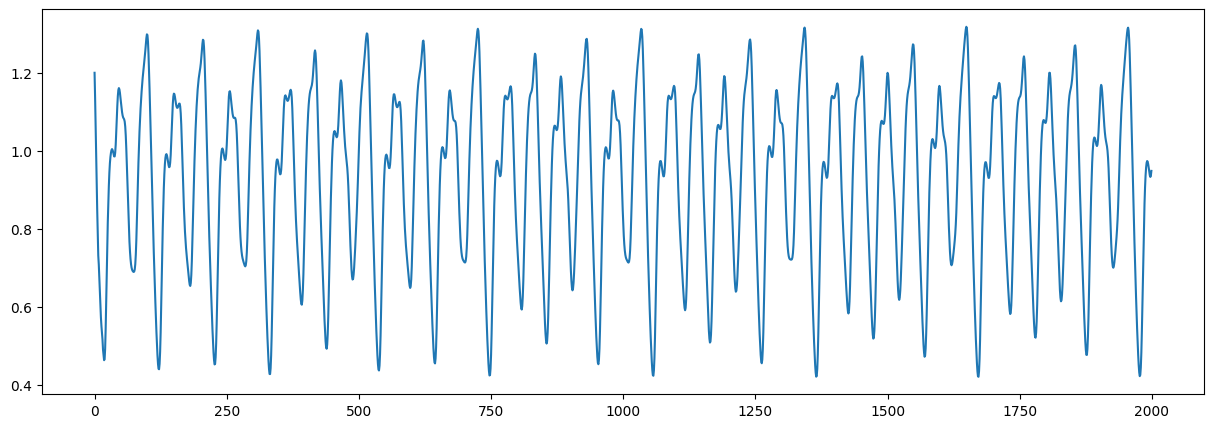

In [1]:
from reservoirpy.datasets import mackey_glass
import pylab as plt

# generate time series
time_steps = 2000
time_series = mackey_glass(time_steps)

# plot time series
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(time_series)
plt.show()

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from lstm import make_windows

# make sliding windows
in_size = 4  # (4, 8, 16)
out_size = 140  # (1, 70, 140)
X, Y = make_windows(time_series, in_size=in_size, out_size=out_size)

# split train and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, shuffle=False)

# normalize
x_scaler = StandardScaler()
y_scaler = StandardScaler() 
X_train = x_scaler.fit_transform(X_train.reshape(X_train.shape[0], -1)).reshape(X_train.shape)
X_test = x_scaler.transform(X_test.reshape(X_test.shape[0], -1)).reshape(X_test.shape)
Y_train = y_scaler.fit_transform(Y_train)
Y_test = y_scaler.transform(Y_test)

In [3]:
import jax
import jax.numpy as jnp
import numpy as np
import optax
from lstm import LSTM
from lstm import create_train_state, train_step, eval_step

# build LSTM model
hidden_size = 128
learning_rate = 0.01
rng = jax.random.PRNGKey(0)
model = LSTM(hidden_size=hidden_size, out_size=out_size)
optimizer = optax.adam(learning_rate=learning_rate)
state = create_train_state(rng, model, optimizer, in_size=in_size)

# train model
batch_size = 32
epochs = 100
num_train = X_train.shape[0]
train_mse_history = []
test_mse_history = []
for epoch in range(1, epochs + 1):
    train_losses = []
    perm = np.random.permutation(num_train)
    for i in range(0, num_train, batch_size):
        batch_idx = perm[i:i + batch_size]
        xb = jnp.asarray(X_train[batch_idx])
        yb = jnp.asarray(Y_train[batch_idx])
        state, loss = train_step(state, xb, yb)
        train_losses.append(float(loss))
    train_mse = float(np.mean(train_losses))
    test_mse = float(eval_step(state, jnp.asarray(X_test), jnp.asarray(Y_test)))
    train_mse_history.append(train_mse)
    test_mse_history.append(test_mse)

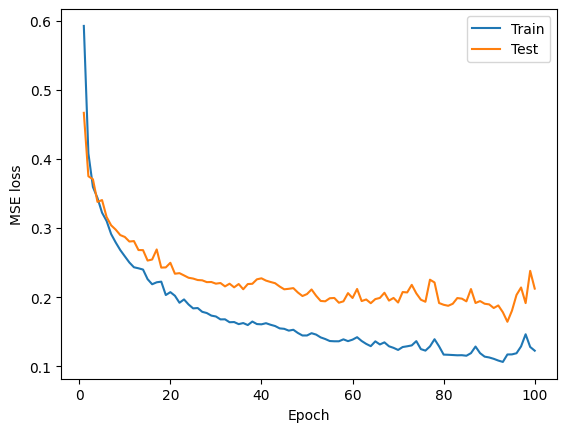

In [4]:
fig, ax = plt.subplots()
ax.plot(np.arange(1, epochs + 1), train_mse_history, label="Train")
ax.plot(np.arange(1, epochs + 1), test_mse_history, label="Test")
ax.set_xlabel("Epoch")
ax.set_ylabel("MSE loss")
ax.legend()
plt.show()

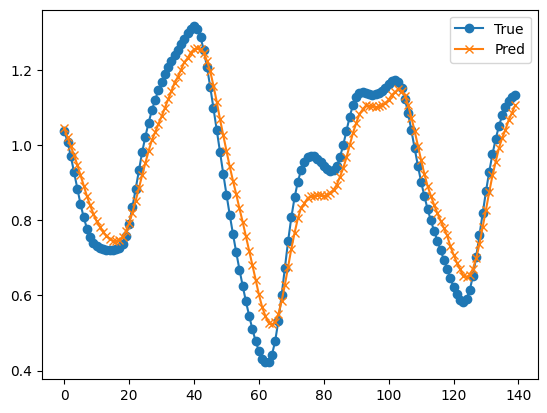

In [5]:
pred_test = np.array(state.apply_fn(state.params, jnp.asarray(X_test)))
pred_test = y_scaler.inverse_transform(pred_test)
Y_test_raw = y_scaler.inverse_transform(Y_test)

idx = 0
true_horizon = Y_test_raw[idx]
pred_horizon = pred_test[idx]

fig, ax = plt.subplots()
ax.plot(np.arange(out_size), true_horizon, marker="o", label="True")
ax.plot(np.arange(out_size), pred_horizon, marker="x", label="Pred")
ax.legend()
plt.show()